# Application Fraud Detection 

## Import Libraries

In [78]:
import pandas as pd
import numpy as np
import calendar
import datetime as dt
import scipy.stats as sps
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from matplotlib import pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

## Import Dataset

In [3]:
ori_df=pd.read_csv('applications data.csv')
ori_df_copy=ori_df.copy()

In [4]:
print(ori_df.shape,ori_df_copy.shape)

(1000000, 10) (1000000, 10)


## Data Preprocessing

In [5]:
ori_df['date']=pd.to_datetime(ori_df.date.astype(str).apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:]))

### collect OOT index 

In [6]:
i_oot=ori_df[ori_df.date>='2016-11-01'].index
i_oot

Int64Index([833507, 833508, 833509, 833510, 833511, 833512, 833513, 833514,
            833515, 833516,
            ...
            999990, 999991, 999992, 999993, 999994, 999995, 999996, 999997,
            999998, 999999],
           dtype='int64', length=166493)

In [7]:
i_his=ori_df[ori_df.date<'2016-11-01'].index
i_his

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            833497, 833498, 833499, 833500, 833501, 833502, 833503, 833504,
            833505, 833506],
           dtype='int64', length=833507)

## Data Cleaning

In [8]:
ori_df['zip5']=ori_df['zip5'].apply(lambda x:'{0:0>5}'.format(x))

ori_df.loc[ori_df.ssn==999999999,'ssn'] = -ori_df[ori_df.ssn==999999999]['record']
ori_df['ssn']=ori_df['ssn'].apply(lambda x: '{0:0>9}'.format(x))

ori_df.loc[ori_df.address=='123 MAIN ST','address']=ori_df.loc[ori_df.address=='123 MAIN ST','record'].apply(lambda x: str(x)+'RECORD')

ori_df.loc[ori_df.dob==19070726,'dob']=-ori_df[ori_df.dob==19070726]['record']
ori_df['dob']=ori_df['dob'].apply(lambda x: '{0:0>8}'.format(x))

ori_df.loc[ori_df.homephone==9999999999,'homephone']=-ori_df[ori_df.homephone==9999999999]['record']
ori_df['homephone']=ori_df['homephone'].apply(lambda x: '{0:0>10}'.format(x))

## Candidate Variables

In [9]:
ori_df['name']=ori_df.firstname+ori_df.lastname
ori_df['fulladdress']=ori_df.address+ori_df.zip5
ori_df['name_dob']=ori_df.name+ori_df.dob
ori_df['name_fulladdress']=ori_df.name+ori_df.fulladdress
ori_df['name_homephone']=ori_df.name+ori_df.homephone
ori_df['fulladdress_dob']=ori_df.fulladdress+ori_df.dob
ori_df['fulladdress_homephone']=ori_df.fulladdress+ori_df.homephone
ori_df['dob_homephone']=ori_df.dob+ori_df.homephone
ori_df['homephone_name_dob']=ori_df.homephone+ori_df.name_dob

In [10]:
for field in list(ori_df.iloc[:,np.r_[3:9,12:15]].columns):
  ori_df['ssn_'+field]=ori_df.ssn+ori_df[field]

In [11]:
ori_df['dow']=ori_df.date.apply(lambda x:calendar.day_name[x.weekday()])

In [12]:
train_test=ori_df.iloc[i_his,:]

In [13]:
c=4
nmid=20
y_avg=train_test['fraud_label'].mean()
y_dow=train_test.groupby('dow')['fraud_label'].mean()
num=train_test.groupby('dow').size()
y_dow_smooth=y_avg+(y_dow-y_avg)/(1+np.exp(-(num-nmid)/c))
ori_df['dow_risk']=ori_df.dow.map(y_dow_smooth)

In [14]:
attributes=list(ori_df.iloc[:,np.r_[2,5,8,10:28]])

In [100]:
df1=ori_df.copy()
final=ori_df.copy()
df1['check_date']=df1.date
df1['check_record']=df1.record

In [101]:
for entity in attributes:
    df_l=df1[['record','date',entity]]
    df_r=df1[['check_record','check_date',entity]]
    temp=pd.merge(df_l,df_r,left_on=entity,right_on=entity)
    
    #day since
    day_since_df=temp[temp.record>temp.check_record][['record','date','check_date']].groupby('record')[['date','check_date']].last()
    mapper=(day_since_df.date-day_since_df.check_date).dt.days
    final[entity+'_day_since']=final.record.map(mapper)
    final[entity+'_day_since'].fillna(365,inplace=True)
    print(f'\n{entity}_day_since ---> Done')
    
    #velocity
    for offset_t in [0,1,3,7,14,30,60]:
        count_day_df=temp[(temp.check_date>=(temp.date-dt.timedelta(offset_t)))
                         &(temp.record>=temp.check_record)]
        col_name=f'{entity}_count_{offset_t}'
        mapper2=count_day_df.groupby('record')[entity].count()
        final[col_name]=final.record.map(mapper2)
        print(f'{entity}_count_{str(offset_t)} --> Done')


ssn_day_since ---> Done
ssn_count_0 --> Done
ssn_count_1 --> Done
ssn_count_3 --> Done
ssn_count_7 --> Done
ssn_count_14 --> Done
ssn_count_30 --> Done
ssn_count_60 --> Done

address_day_since ---> Done
address_count_0 --> Done
address_count_1 --> Done
address_count_3 --> Done
address_count_7 --> Done
address_count_14 --> Done
address_count_30 --> Done
address_count_60 --> Done

homephone_day_since ---> Done
homephone_count_0 --> Done
homephone_count_1 --> Done
homephone_count_3 --> Done
homephone_count_7 --> Done
homephone_count_14 --> Done
homephone_count_30 --> Done
homephone_count_60 --> Done

name_day_since ---> Done
name_count_0 --> Done
name_count_1 --> Done
name_count_3 --> Done
name_count_7 --> Done
name_count_14 --> Done
name_count_30 --> Done
name_count_60 --> Done

fulladdress_day_since ---> Done
fulladdress_count_0 --> Done
fulladdress_count_1 --> Done
fulladdress_count_3 --> Done
fulladdress_count_7 --> Done
fulladdress_count_14 --> Done
fulladdress_count_30 --> Done
ful

In [102]:
#relative velocity
for att in attributes:
  for d in ['0','1']:
    for dd in ['3','7','14','30','60']:
      final[att+'_count_'+d+'_by_'+dd]=final[att+'_count_'+d]/(final[att+'_count_'+dd]/float(dd))

In [104]:
for att in attributes:
    for d in ['7','14','30','60']:
        for dd in['0','1','3']:
            final[att+'_pct_increase_'+dd+'_to_'+d]=(final[att+'_count_'+d]-final[att+'_count_'+dd])/final[att+'_count_'+dd]

In [105]:
identity=['ssn','dob','name','name_dob']
contact=['homephone']
for idt in identity:
    for con in contact:
        df_l=df1[['record',idt,'date',con]]
        df_r=df1[[idt,'check_date',con]].rename(columns={idt:idt+"2"})
        temp=pd.merge(df_l,df_r,left_on=con,right_on=con)
        for offset_t in [0,1,3,7,14,30,60]:
            count_idt_df= temp[(temp['check_date']>=(temp['date']- dt.timedelta(offset_t)))\
                               &(temp['check_date']<=temp['date'])]
            col_name=f'{idt}_count_wSame_{con}_{offset_t}'
            mapper=count_idt_df.groupby('record')[idt+"2"].nunique()
            final[col_name]=final['record'].map(mapper)
            print(f'{col_name}--->Done')

ssn_count_wSame_homephone_0--->Done
ssn_count_wSame_homephone_1--->Done
ssn_count_wSame_homephone_3--->Done
ssn_count_wSame_homephone_7--->Done
ssn_count_wSame_homephone_14--->Done
ssn_count_wSame_homephone_30--->Done
ssn_count_wSame_homephone_60--->Done
dob_count_wSame_homephone_0--->Done
dob_count_wSame_homephone_1--->Done
dob_count_wSame_homephone_3--->Done
dob_count_wSame_homephone_7--->Done
dob_count_wSame_homephone_14--->Done
dob_count_wSame_homephone_30--->Done
dob_count_wSame_homephone_60--->Done
name_count_wSame_homephone_0--->Done
name_count_wSame_homephone_1--->Done
name_count_wSame_homephone_3--->Done
name_count_wSame_homephone_7--->Done
name_count_wSame_homephone_14--->Done
name_count_wSame_homephone_30--->Done
name_count_wSame_homephone_60--->Done
name_dob_count_wSame_homephone_0--->Done
name_dob_count_wSame_homephone_1--->Done
name_dob_count_wSame_homephone_3--->Done
name_dob_count_wSame_homephone_7--->Done
name_dob_count_wSame_homephone_14--->Done
name_dob_count_wSame_h

In [106]:
identity=['fulladdress','address']
contact=['ssn','name_dob']
for idt in identity:
    for con in contact:
        df_l=df1[['record',idt,'date',con]]
        df_r=df1[[idt,'check_date',con]].rename(columns={idt:idt+"2"})
        temp=pd.merge(df_l,df_r,left_on=con,right_on=con)
        for offset_t in [0,1,3,7,14,30,60]:
            count_idt_df= temp[(temp['check_date']>=(temp['date']- dt.timedelta(offset_t)))\
                               &(temp['check_date']<=temp['date'])]
            col_name=f'{idt}_count_wSame_{con}_{offset_t}'
            mapper=count_idt_df.groupby('record')[idt+"2"].nunique()
            final[col_name]=final['record'].map(mapper)
            print(f'{col_name}--->Done')

fulladdress_count_wSame_ssn_0--->Done
fulladdress_count_wSame_ssn_1--->Done
fulladdress_count_wSame_ssn_3--->Done
fulladdress_count_wSame_ssn_7--->Done
fulladdress_count_wSame_ssn_14--->Done
fulladdress_count_wSame_ssn_30--->Done
fulladdress_count_wSame_ssn_60--->Done
fulladdress_count_wSame_name_dob_0--->Done
fulladdress_count_wSame_name_dob_1--->Done
fulladdress_count_wSame_name_dob_3--->Done
fulladdress_count_wSame_name_dob_7--->Done
fulladdress_count_wSame_name_dob_14--->Done
fulladdress_count_wSame_name_dob_30--->Done
fulladdress_count_wSame_name_dob_60--->Done
address_count_wSame_ssn_0--->Done
address_count_wSame_ssn_1--->Done
address_count_wSame_ssn_3--->Done
address_count_wSame_ssn_7--->Done
address_count_wSame_ssn_14--->Done
address_count_wSame_ssn_30--->Done
address_count_wSame_ssn_60--->Done
address_count_wSame_name_dob_0--->Done
address_count_wSame_name_dob_1--->Done
address_count_wSame_name_dob_3--->Done
address_count_wSame_name_dob_7--->Done
address_count_wSame_name_dob_1

## Filter
features: 687 -> 80

In [108]:
i_stable=final[(final.date>'2016-01-14')&(final.date<'2016-11-01')].index

In [109]:
mydata=final.iloc[i_stable,:]
mydata.shape

(794996, 716)

In [110]:
goods=mydata[mydata.fraud_label==0]
bads=mydata[mydata.fraud_label==1]
print(goods.shape,bads.shape)

(783510, 716) (11486, 716)


In [111]:
KSFDR=pd.DataFrame(columns=['Variable','KS','FDR at 3%'])
KSFDR.Variable=mydata.columns

In [112]:
#Calculate univariate KS
i=0
for column in mydata:
    KSFDR['KS'][i]=sps.ks_2samp(goods[column],bads[column])[0]
    i+=1

In [113]:
#Calculate univariate FDR@3%
numbads=len(bads)
j=0
#选取3%的data
topRows = int(round(len(mydata)*0.03))
for column in KSFDR['Variable']:
    if column != 'fraud_label':
        temp = mydata[[column,'fraud_label']].copy()
    
        temp0 = temp.sort_values(column,ascending=False)
        temp1 = temp0.head(topRows)
        temp2 = temp0.tail(topRows)
        needed1 = temp1.loc[:,'fraud_label']
        needed2 = temp2.loc[:,'fraud_label']
        FDR1 = sum(needed1)/numbads
        FDR2 = sum(needed2)/numbads
        FDRate = np.maximum(FDR1,FDR2)
        print(FDRate)
        KSFDR.loc[j, 'FDR at 3%'] = FDRate
    else:
        KSFDR.loc[j, 'FDR at 3%'] = 1
    j = j + 1

0.03482500435312554
0.034912066864008356
0.028469441058680132
0.03499912937489117
0.030384816298102038
0.03230019153752394
0.029165941145742644
0.03334494166811771
0.03308375413546927
0.03499912937489117
0.03230019153752394
0.03499912937489117
0.03499912937489117
0.03499912937489117
0.03230019153752394
0.03230019153752394
0.03334494166811771
0.03308375413546927
0.028469441058680132
0.028469441058680132
0.028469441058680132
0.028469441058680132
0.028469441058680132
0.028469441058680132
0.028469441058680132
0.028469441058680132
0.028469441058680132
0.03021069127633641
0.03378025422253178
0.2538742817342852
0.13494689186836148
0.17543095942886994
0.19832839979104996
0.2186139648267456
0.24020546752568345
0.25352603169075394
0.24708340588542574
0.35530210691276337
0.20842765105345637
0.268936096117012
0.2990597248824656
0.3209994776249347
0.34581229322653667
0.35329966916245864
0.3469441058680132
0.10682570085321261
0.14957339369667422
0.19484589935573743
0.2047710255963782
0.2082535260316

0.2047710255963782
0.1871843983980498
0.15531951941493993
0.1977189622148703
0.14043183005397875
0.1055197631899704
0.2781647222705903
0.20172383771547972
0.13294445411805678
0.30445760055720006
0.22853909106738637
0.16698589587323698
0.26536653317081665
0.17203552150444018
0.11988507748563469
0.2594462824307853
0.16916245864530732
0.11779557722444715
0.10325613790701724
0.050322131290266414
0.03247431655928957
0.0904579488072436
0.046143130767891345
0.0326484415810552
0.07173950896743862
0.04239944279993035
0.031777816472227056
0.055545881943235245
0.03665331708166464
0.02803412850426606
0.1627198328399791
0.14400139300017412
0.10282082535260317
0.16367752045969006
0.10856695107086889
0.07652794706599338
0.18892564861570607
0.13468570433571303
0.09907713738464217
0.12597945324743165
0.08558244819780603
0.06599338324917291
0.27598815949851996
0.20242033780254223
0.13425039178129897
0.30001741250217656
0.22671077833884729
0.16602820825352604
0.2684137210517151
0.18361483545185442
0.1900

In [114]:
KSFDR['rank_ks'] = KSFDR['KS'].rank(ascending = True)
KSFDR['rank_FDR'] = KSFDR['FDR at 3%'].rank(ascending = True)
KSFDR['average_rank'] = (KSFDR['rank_ks'] + KSFDR['rank_FDR']) / 2
KSFDR.sort_values(by=['average_rank'], ascending=False, inplace=True)
KSFDR

,Variable,KS,FDR at 3%,rank_ks,rank_FDR,average_rank
9,fraud_label,1,1,716.0,716.0,716.00
62,fulladdress_day_since,0.33321,0.358349,714.0,715.0,714.50
38,address_day_since,0.334096,0.355302,715.0,714.0,714.50
44,address_count_30,0.332725,0.3533,713.0,712.0,712.50
68,fulladdress_count_30,0.332032,0.354954,712.0,713.0,712.50
...,...,...,...,...,...,...
87,name_homephone_count_0,0.00178246,0.034825,4.0,31.5,17.75
167,ssn_homephone_count_0,0.00179267,0.0347379,6.0,29.0,17.50
183,ssn_name_fulladdress_count_0,0.00177352,0.034825,3.0,31.5,17.25
191,ssn_name_homephone_count_0,0.00170816,0.0346509,2.0,28.0,15.00


In [115]:
filter_list=KSFDR.Variable[:81]
filter_dataset=mydata[filter_list]
filter_dataset.shape

(794996, 81)

# Wrapper 
features: 80 -> 30

In [123]:
filter_dataset_x=filter_dataset.drop('fraud_label',axis=1)
filter_dataset_y=filter_dataset.fraud_label

In [124]:
filter_dataset_x = (filter_dataset_x - filter_dataset_x.mean()) / filter_dataset_x.std()

In [125]:
def fdr_prob(y,y_prob,cutoff=0.03):
    if len(y_prob.shape)!=1:
        y_prob=y_prob[:,-1:]
    num_fraud=len(y[y==1])
    sorted_prob=np.asarray(sorted(zip(y_prob,y),key=lambda x:x[0],reverse=True))
    cutoff_bin=sorted_prob[0:int(len(y)*cutoff),1:]
    return len(cutoff_bin[cutoff_bin==1])/num_fraud

In [126]:
def fdr(classifier,x,y,cutoff=0.03):
    return fdr_prob(y,classifier.predict_proba(x),cutoff)

In [128]:
model = LogisticRegression(penalty='l2', class_weight='balanced')
rfecv = RFECV(model, step=1, cv=2, verbose=2, n_jobs=1, scoring=fdr)

In [129]:
selector=rfecv.fit(filter_dataset_x,filter_dataset_y)

Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 fe

In [130]:
feature_50_col=filter_dataset_x.columns[selector.support_]
feature_50=filter_dataset_x[feature_50_col]

In [131]:
feature_50

,fulladdress_day_since,fulladdress_count_30,fulladdress_count_60,address_count_14,address_count_0_by_14,address_pct_increase_0_to_14,fulladdress_pct_increase_0_to_30,fulladdress_count_0_by_30,fulladdress_pct_increase_0_to_14,address_count_3,...,ssn_lastname_count_0_by_30,ssn_name_dob_pct_increase_0_to_30,fulladdress_homephone_pct_increase_0_to_30,fulladdress_homephone_count_0_by_30,address_pct_increase_1_to_14,dob_count_wSame_homephone_7,ssn_count_wSame_homephone_7,name_count_wSame_homephone_7,dob_count_wSame_homephone_3,fulladdress_pct_increase_1_to_14
38511,0.388026,-0.103583,-0.140844,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.090566,-0.061627,...,0.173868,-0.128797,-0.121792,0.168888,-0.118863,0.777709,0.754066,0.754168,-0.513582,-0.103864
38512,0.388026,-0.103583,-0.140844,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.090566,-0.061627,...,0.173868,-0.128797,-0.121792,0.168888,-0.118863,0.777709,0.754066,0.754168,0.491231,-0.103864
38513,0.388026,-0.103583,-0.140844,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.090566,-0.061627,...,0.173868,-0.128797,-0.121792,0.168888,-0.118863,-0.757168,-0.757296,-0.757299,-0.513582,-0.103864
38514,0.388026,-0.103583,-0.140844,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.090566,-0.061627,...,0.173868,-0.128797,-0.121792,0.168888,-0.118863,-0.757168,-0.757296,-0.757299,-0.513582,-0.103864
38515,0.388026,-0.103583,-0.140844,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.090566,-0.061627,...,0.173868,-0.128797,-0.121792,0.168888,-0.118863,-0.757168,-0.757296,-0.757299,-0.513582,-0.103864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833502,-2.939707,-0.103583,1.345869,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.090566,-0.061627,...,0.173868,-0.128797,-0.121792,0.168888,-0.118863,1.545147,1.509748,1.509901,0.491231,-0.103864
833503,-1.776517,-0.103583,-0.140844,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.090566,-0.061627,...,0.173868,-0.128797,-0.121792,0.168888,-0.118863,1.545147,1.509748,1.509901,0.491231,-0.103864
833504,0.388026,-0.103583,-0.140844,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.090566,-0.061627,...,0.173868,-0.128797,-0.121792,0.168888,-0.118863,-0.757168,-0.757296,-0.757299,-0.513582,-0.103864
833505,0.388026,-0.103583,-0.140844,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.090566,-0.061627,...,0.173868,-0.128797,-0.121792,0.168888,-0.118863,1.545147,1.509748,1.509901,1.496044,-0.103864


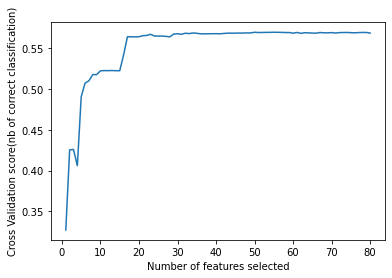

In [139]:
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross Validation score(nb of correct classification)')
plt.plot(range(1,len(selector.grid_scores_)+1),selector.grid_scores_)
plt.show()

In [140]:
selector2=rfecv.fit(feature_50,filter_dataset_y)

Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 fe

In [141]:
feature_43_col=feature_50.columns[selector2.support_]
feature_43=feature_50[feature_43_col]

In [142]:
feature_43

,fulladdress_day_since,fulladdress_count_30,address_count_14,address_count_0_by_14,address_pct_increase_0_to_14,fulladdress_pct_increase_0_to_30,fulladdress_count_0_by_30,address_count_3,fulladdress_count_0_by_7,fulladdress_pct_increase_0_to_7,...,ssn_firstname_count_0_by_30,ssn_firstname_pct_increase_0_to_30,ssn_lastname_count_0_by_30,ssn_name_dob_pct_increase_0_to_30,fulladdress_homephone_pct_increase_0_to_30,fulladdress_homephone_count_0_by_30,address_pct_increase_1_to_14,dob_count_wSame_homephone_7,name_count_wSame_homephone_7,dob_count_wSame_homephone_3
38511,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.173861,-0.130134,0.173868,-0.128797,-0.121792,0.168888,-0.118863,0.777709,0.754168,-0.513582
38512,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.173861,-0.130134,0.173868,-0.128797,-0.121792,0.168888,-0.118863,0.777709,0.754168,0.491231
38513,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.173861,-0.130134,0.173868,-0.128797,-0.121792,0.168888,-0.118863,-0.757168,-0.757299,-0.513582
38514,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.173861,-0.130134,0.173868,-0.128797,-0.121792,0.168888,-0.118863,-0.757168,-0.757299,-0.513582
38515,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.173861,-0.130134,0.173868,-0.128797,-0.121792,0.168888,-0.118863,-0.757168,-0.757299,-0.513582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833502,-2.939707,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.173861,-0.130134,0.173868,-0.128797,-0.121792,0.168888,-0.118863,1.545147,1.509901,0.491231
833503,-1.776517,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.173861,-0.130134,0.173868,-0.128797,-0.121792,0.168888,-0.118863,1.545147,1.509901,0.491231
833504,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.173861,-0.130134,0.173868,-0.128797,-0.121792,0.168888,-0.118863,-0.757168,-0.757299,-0.513582
833505,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.173861,-0.130134,0.173868,-0.128797,-0.121792,0.168888,-0.118863,1.545147,1.509901,1.496044


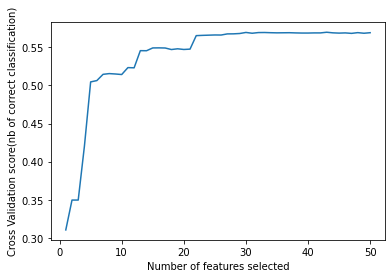

In [143]:
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross Validation score(nb of correct classification)')
plt.plot(range(1,len(selector2.grid_scores_)+1),selector2.grid_scores_)
plt.show()

In [144]:
selector3=rfecv.fit(feature_43,filter_dataset_y)

Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 fe

In [145]:
feature_42_col=feature_43.columns[selector3.support_]
feature_42=feature_43[feature_42_col]

In [146]:
feature_42

,fulladdress_day_since,fulladdress_count_30,address_count_14,address_count_0_by_14,address_pct_increase_0_to_14,fulladdress_pct_increase_0_to_30,fulladdress_count_0_by_30,address_count_3,fulladdress_count_0_by_7,fulladdress_pct_increase_0_to_7,...,ssn_firstname_count_0_by_30,ssn_firstname_pct_increase_0_to_30,ssn_lastname_count_0_by_30,ssn_name_dob_pct_increase_0_to_30,fulladdress_homephone_pct_increase_0_to_30,fulladdress_homephone_count_0_by_30,address_pct_increase_1_to_14,dob_count_wSame_homephone_7,name_count_wSame_homephone_7,dob_count_wSame_homephone_3
38511,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.173861,-0.130134,0.173868,-0.128797,-0.121792,0.168888,-0.118863,0.777709,0.754168,-0.513582
38512,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.173861,-0.130134,0.173868,-0.128797,-0.121792,0.168888,-0.118863,0.777709,0.754168,0.491231
38513,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.173861,-0.130134,0.173868,-0.128797,-0.121792,0.168888,-0.118863,-0.757168,-0.757299,-0.513582
38514,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.173861,-0.130134,0.173868,-0.128797,-0.121792,0.168888,-0.118863,-0.757168,-0.757299,-0.513582
38515,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.173861,-0.130134,0.173868,-0.128797,-0.121792,0.168888,-0.118863,-0.757168,-0.757299,-0.513582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833502,-2.939707,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.173861,-0.130134,0.173868,-0.128797,-0.121792,0.168888,-0.118863,1.545147,1.509901,0.491231
833503,-1.776517,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.173861,-0.130134,0.173868,-0.128797,-0.121792,0.168888,-0.118863,1.545147,1.509901,0.491231
833504,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.173861,-0.130134,0.173868,-0.128797,-0.121792,0.168888,-0.118863,-0.757168,-0.757299,-0.513582
833505,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.173861,-0.130134,0.173868,-0.128797,-0.121792,0.168888,-0.118863,1.545147,1.509901,1.496044


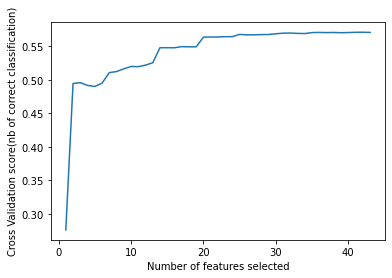

In [147]:
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross Validation score(nb of correct classification)')
plt.plot(range(1,len(selector3.grid_scores_)+1),selector3.grid_scores_)
plt.show()

In [148]:
selector4=rfecv.fit(feature_42,filter_dataset_y)

Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 fe

In [149]:
feature_36_col=feature_42.columns[selector4.support_]
feature_36=feature_42[feature_36_col]

In [150]:
feature_36

,fulladdress_day_since,fulladdress_count_30,address_count_14,address_count_0_by_14,address_pct_increase_0_to_14,fulladdress_pct_increase_0_to_30,fulladdress_count_0_by_30,address_count_3,fulladdress_count_0_by_7,fulladdress_pct_increase_0_to_7,...,address_count_1_by_14,ssn_firstname_count_0_by_30,ssn_firstname_pct_increase_0_to_30,ssn_lastname_count_0_by_30,fulladdress_homephone_pct_increase_0_to_30,fulladdress_homephone_count_0_by_30,address_pct_increase_1_to_14,dob_count_wSame_homephone_7,name_count_wSame_homephone_7,dob_count_wSame_homephone_3
38511,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.141844,0.173861,-0.130134,0.173868,-0.121792,0.168888,-0.118863,0.777709,0.754168,-0.513582
38512,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.141844,0.173861,-0.130134,0.173868,-0.121792,0.168888,-0.118863,0.777709,0.754168,0.491231
38513,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.141844,0.173861,-0.130134,0.173868,-0.121792,0.168888,-0.118863,-0.757168,-0.757299,-0.513582
38514,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.141844,0.173861,-0.130134,0.173868,-0.121792,0.168888,-0.118863,-0.757168,-0.757299,-0.513582
38515,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.141844,0.173861,-0.130134,0.173868,-0.121792,0.168888,-0.118863,-0.757168,-0.757299,-0.513582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833502,-2.939707,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.141844,0.173861,-0.130134,0.173868,-0.121792,0.168888,-0.118863,1.545147,1.509901,0.491231
833503,-1.776517,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.141844,0.173861,-0.130134,0.173868,-0.121792,0.168888,-0.118863,1.545147,1.509901,0.491231
833504,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.141844,0.173861,-0.130134,0.173868,-0.121792,0.168888,-0.118863,-0.757168,-0.757299,-0.513582
833505,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,0.141844,0.173861,-0.130134,0.173868,-0.121792,0.168888,-0.118863,1.545147,1.509901,1.496044


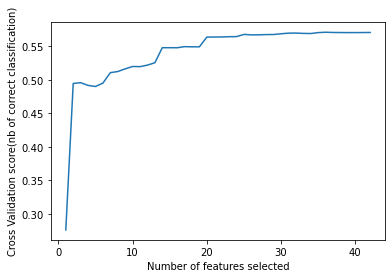

In [151]:
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross Validation score(nb of correct classification)')
plt.plot(range(1,len(selector4.grid_scores_)+1),selector4.grid_scores_)
plt.show()

In [152]:
selector5=rfecv.fit(feature_36,filter_dataset_y)

Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 fea

In [153]:
feature_35_col=feature_36.columns[selector5.support_]
feature_35=feature_36[feature_35_col]

In [154]:
feature_35

,fulladdress_day_since,fulladdress_count_30,address_count_14,address_count_0_by_14,address_pct_increase_0_to_14,fulladdress_pct_increase_0_to_30,fulladdress_count_0_by_30,address_count_3,fulladdress_count_0_by_7,fulladdress_pct_increase_0_to_7,...,ssn_name_dob_count_14,ssn_firstname_count_0_by_30,ssn_firstname_pct_increase_0_to_30,ssn_lastname_count_0_by_30,fulladdress_homephone_pct_increase_0_to_30,fulladdress_homephone_count_0_by_30,address_pct_increase_1_to_14,dob_count_wSame_homephone_7,name_count_wSame_homephone_7,dob_count_wSame_homephone_3
38511,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,-0.071327,0.173861,-0.130134,0.173868,-0.121792,0.168888,-0.118863,0.777709,0.754168,-0.513582
38512,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,-0.071327,0.173861,-0.130134,0.173868,-0.121792,0.168888,-0.118863,0.777709,0.754168,0.491231
38513,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,-0.071327,0.173861,-0.130134,0.173868,-0.121792,0.168888,-0.118863,-0.757168,-0.757299,-0.513582
38514,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,-0.071327,0.173861,-0.130134,0.173868,-0.121792,0.168888,-0.118863,-0.757168,-0.757299,-0.513582
38515,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,-0.071327,0.173861,-0.130134,0.173868,-0.121792,0.168888,-0.118863,-0.757168,-0.757299,-0.513582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833502,-2.939707,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,-0.071327,0.173861,-0.130134,0.173868,-0.121792,0.168888,-0.118863,1.545147,1.509901,0.491231
833503,-1.776517,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,-0.071327,0.173861,-0.130134,0.173868,-0.121792,0.168888,-0.118863,1.545147,1.509901,0.491231
833504,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,-0.071327,0.173861,-0.130134,0.173868,-0.121792,0.168888,-0.118863,-0.757168,-0.757299,-0.513582
833505,0.388026,-0.103583,-0.089492,0.150003,-0.105202,-0.127994,0.182389,-0.061627,0.103052,-0.070946,...,-0.071327,0.173861,-0.130134,0.173868,-0.121792,0.168888,-0.118863,1.545147,1.509901,1.496044


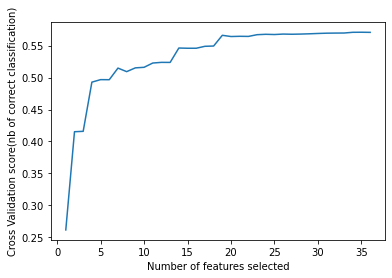

In [156]:
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross Validation score(nb of correct classification)')
plt.plot(range(1,len(selector5.grid_scores_)+1),selector5.grid_scores_)
plt.show()

In [157]:
selector6=RFE(estimator=model, n_features_to_select=30, step=1,verbose=2)
selector6.fit(feature_35,filter_dataset_y)

Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.


RFE(estimator=LogisticRegression(class_weight='balanced'),
    n_features_to_select=30, verbose=2)

In [158]:
wrapper_col=feature_35.columns[selector6.support_]
wrapper_col

Index(['fulladdress_count_30', 'address_count_14',
       'fulladdress_pct_increase_0_to_30', 'fulladdress_count_0_by_30',
       'address_count_3', 'fulladdress_count_0_by_7',
       'fulladdress_pct_increase_0_to_7', 'address_count_1',
       'fulladdress_count_1', 'fulladdress_homephone_count_30',
       'fulladdress_homephone_day_since', 'ssn_dob_day_since',
       'name_dob_day_since', 'ssn_name_dob_day_since', 'ssn_name_dob_count_30',
       'name_dob_count_30', 'ssn_firstname_count_60',
       'fulladdress_homephone_count_14', 'name_dob_count_60',
       'ssn_firstname_count_14', 'name_dob_count_14', 'ssn_name_dob_count_14',
       'ssn_firstname_count_0_by_30', 'ssn_firstname_pct_increase_0_to_30',
       'ssn_lastname_count_0_by_30',
       'fulladdress_homephone_pct_increase_0_to_30',
       'fulladdress_homephone_count_0_by_30', 'address_pct_increase_1_to_14',
       'dob_count_wSame_homephone_7', 'name_count_wSame_homephone_7'],
      dtype='object')

In [159]:
wrapper_dataset=final[wrapper_col]

In [160]:
wrapper_dataset['fraud_label']=final.fraud_label

In [161]:
wrapper_dataset

,fulladdress_count_30,address_count_14,fulladdress_pct_increase_0_to_30,fulladdress_count_0_by_30,address_count_3,fulladdress_count_0_by_7,fulladdress_pct_increase_0_to_7,address_count_1,fulladdress_count_1,fulladdress_homephone_count_30,...,ssn_name_dob_count_14,ssn_firstname_count_0_by_30,ssn_firstname_pct_increase_0_to_30,ssn_lastname_count_0_by_30,fulladdress_homephone_pct_increase_0_to_30,fulladdress_homephone_count_0_by_30,address_pct_increase_1_to_14,dob_count_wSame_homephone_7,name_count_wSame_homephone_7,fraud_label
0,1,1,0.0,30.0,1,7.0,0.0,1,1,1,...,1,30.0,0.0,30.0,0.0,30.0,0.0,2,2,0
1,1,1,0.0,30.0,1,7.0,0.0,1,1,1,...,1,30.0,0.0,30.0,0.0,30.0,0.0,2,2,1
2,1,1,0.0,30.0,1,7.0,0.0,1,1,1,...,1,30.0,0.0,30.0,0.0,30.0,0.0,1,1,0
3,1,1,0.0,30.0,1,7.0,0.0,1,1,1,...,1,30.0,0.0,30.0,0.0,30.0,0.0,1,1,0
4,1,1,0.0,30.0,1,7.0,0.0,1,1,1,...,1,30.0,0.0,30.0,0.0,30.0,0.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1,1,0.0,30.0,1,7.0,0.0,1,1,1,...,1,30.0,0.0,30.0,0.0,30.0,0.0,1,1,0
999996,1,1,0.0,30.0,1,7.0,0.0,1,1,1,...,1,30.0,0.0,30.0,0.0,30.0,0.0,2,2,0
999997,1,1,0.0,30.0,1,7.0,0.0,1,1,1,...,1,30.0,0.0,30.0,0.0,30.0,0.0,2,2,0
999998,1,1,0.0,30.0,1,7.0,0.0,1,1,1,...,1,30.0,0.0,30.0,0.0,30.0,0.0,4,4,0


## Simple Performance testing

### Split Dataset

In [163]:
oot=wrapper_dataset.iloc[i_oot,:]
oot_x=oot.drop('fraud_label',axis=1)
oot_y=oot.fraud_label

his=wrapper_dataset.iloc[i_his,:]
x=his.drop('fraud_label',axis=1)
y=his.fraud_label

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33,random_state=0)

In [164]:
print('oot_x: ',oot_x.shape,'\noot_y: ',oot_y.shape,'\nx_train: ',x_train.shape,
     '\nx_test: ',x_test.shape,'\ny_train: ',y_train.shape,'\ny_test: ',y_test.shape,
     '\ntotal row number: ',oot_x.shape[0]+x_train.shape[0]+x_test.shape[0])

oot_x:  (166493, 30) 
oot_y:  (166493,) 
x_train:  (558449, 30) 
x_test:  (275058, 30) 
y_train:  (558449,) 
y_test:  (275058,) 
total row number:  1000000


In [165]:
def f(model,train_variables,train_label,test_variables,test_label,oot_variables,oot_label):
    print('start model training')
    m=model.fit(train_variables,train_label)
    print('finish model training')
    
    print('\nstart recording training probability ')
    prob_train=m.predict_proba(train_variables)
    train_table=pd.DataFrame(prob_train)
    train_table['true_label']=train_label.values
    print('finish recording training probability')
    train_3=train_table.sort_values([1],ascending=False).head(int(0.03*len(train_table)))
    train_numbads=sum(train_label)
    train_ratio=round(sum(train_3.true_label)/train_numbads,3)
    print('finish calculating training ratio\ntraining ratio: ',train_ratio)
    
    print('\nstart recording testing probability ')
    prob_test=m.predict_proba(test_variables)
    test_table=pd.DataFrame(prob_test)
    test_table['true_label']=test_label.values
    print('finish recording testing probability')
    test_3=test_table.sort_values([1],ascending=False).head(int(0.03*len(test_table)))
    test_numbads=sum(test_label)
    test_ratio=round(sum(test_3.true_label)/test_numbads,3)
    print('finish calculating testing ratio\ntesting ratio: ',test_ratio)
    
    print('\nstart recording oot probability ')
    prob_oot=m.predict_proba(oot_variables)
    oot_table=pd.DataFrame(prob_oot)
    oot_table['true_label']=oot_label.values
    print('finish recording oot probability')
    oot_3=oot_table.sort_values([1],ascending=False).head(int(0.03*len(oot_table)))
    oot_numbads=sum(oot_label)
    oot_ratio=round(sum(oot_3.true_label)/oot_numbads,3)
    print('finish calculating oot ratio\noot ratio: ',oot_ratio)
    
    
    return [train_ratio,test_ratio,oot_ratio]

In [166]:
#logistic regression test
lr_1=LogisticRegression(penalty='l2', class_weight='balanced')
r_lr_1=f(lr_1,x_train,y_train,x_test,y_test,oot_x,oot_y)
r_lr_1

start model training
finish model training

start recording training probability 
finish recording training probability
finish calculating training ratio
training ratio:  0.533

start recording testing probability 
finish recording testing probability
finish calculating testing ratio
testing ratio:  0.54

start recording oot probability 
finish recording oot probability
finish calculating oot ratio
oot ratio:  0.519


[0.533, 0.54, 0.519]

In [167]:
#xgboost test
bt_3=xgb.XGBClassifier(max_depth=5, n_estimators=500, learning_rate=0.1,objective='binary:logistic',eval_metric='logloss')
r_bt_3=f(bt_3,x_train,y_train,x_test,y_test,oot_x,oot_y)
r_bt_3

start model training
finish model training

start recording training probability 
finish recording training probability
finish calculating training ratio
training ratio:  0.578

start recording testing probability 
finish recording testing probability
finish calculating testing ratio
testing ratio:  0.579

start recording oot probability 
finish recording oot probability
finish calculating oot ratio
oot ratio:  0.561


[0.578, 0.579, 0.561]

#### Looks good, feature engineering can be finished and we can start modeling.